
Original Series Stationarity Check:
ADF Statistic: -2.7862955756763235
p-value: 0.060258169716754635
❌ Time series is NOT stationary. Differencing required.

After Differencing Stationarity Check:
ADF Statistic: -15.750882113052787
p-value: 1.2237472923444142e-28
✅ Time series is stationary.


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

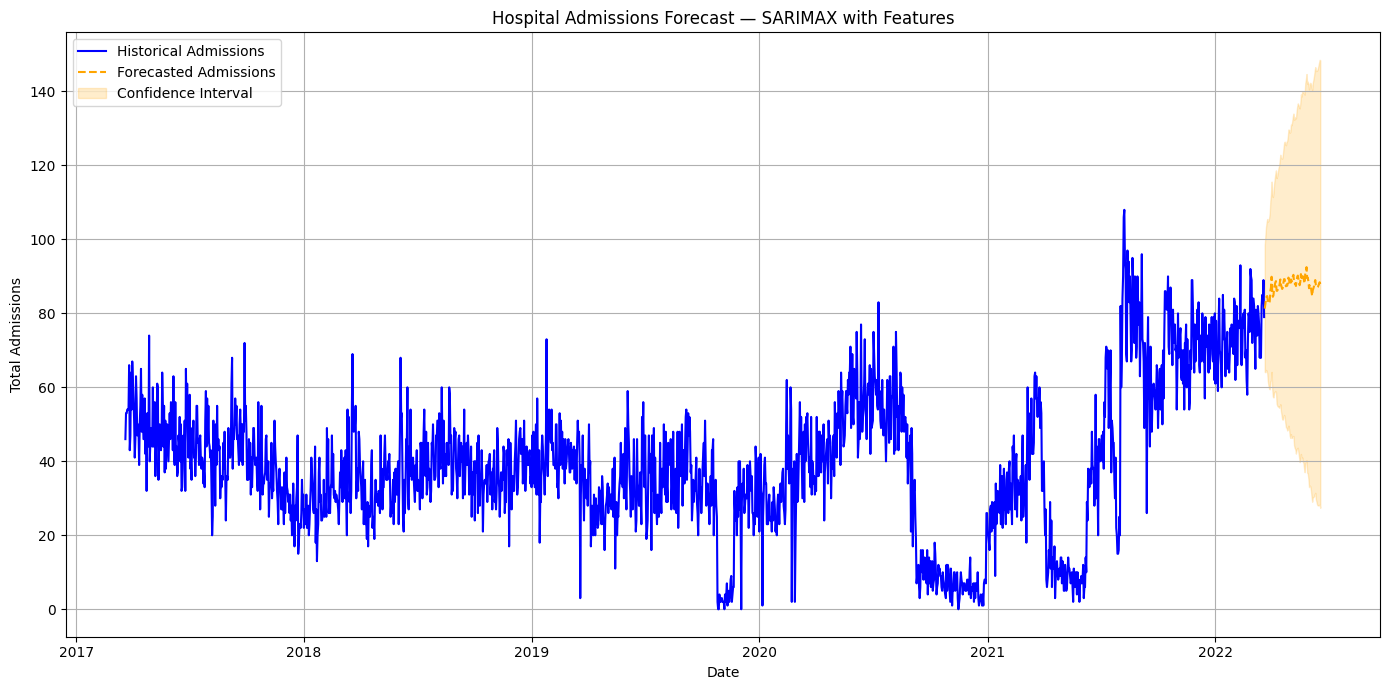


Forecast Table (first 15 rows):
     Forecast_Date  Predicted_Admissions  Lower_CI  Upper_CI
1819    2022-03-21                 81.29     64.18     98.39
1820    2022-03-22                 82.48     64.09    100.87
1821    2022-03-23                 83.97     64.71    103.23
1822    2022-03-24                 84.56     64.49    104.63
1823    2022-03-25                 84.68     63.84    105.52
1824    2022-03-26                 83.23     61.65    104.82
1825    2022-03-27                 82.74     60.44    105.05
1826    2022-03-28                 82.71     59.64    105.77
1827    2022-03-29                 83.25     59.48    107.01
1828    2022-03-30                 86.02     61.58    110.46
1829    2022-03-31                 86.96     61.87    112.06
1830    2022-04-01                 89.90     64.17    115.64
1831    2022-04-02                 85.93     59.57    112.28
1832    2022-04-03                 84.48     57.52    111.45
1833    2022-04-04                 84.88     57.27  

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
 
# Load data
hospital_data = pd.read_csv('feature_engineering_data.csv')
hospital_data['ResidentDate'] = pd.to_datetime(hospital_data['ResidentDate'])
hospital_data.set_index('ResidentDate', inplace=True)
 
# Target variable
y = hospital_data['Total_Admissions']
 
# Exogenous variables — meaningful drivers of spikes
exog_vars = [
    'is_weekend', 'season', 'temperature_max', 'temperature_min',
    'temp_range', 'precipitation', 'is_rain', 'Festival',
    'pandemic_flag', 'disaster_flag'
]
exog = hospital_data[exog_vars]
 
# Stationarity check
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("✅ Time series is stationary.")
    else:
        print("❌ Time series is NOT stationary. Differencing required.")
 
print("\nOriginal Series Stationarity Check:")
test_stationarity(y)
 
# If needed, differencing:
y_diff = y.diff().dropna()
print("\nAfter Differencing Stationarity Check:")
test_stationarity(y_diff)
 
# SARIMAX model — using your external features
p, d, q = 1, 1, 1  # basic ARIMA part
P, D, Q, m = 1, 1, 1, 7  # seasonal part, weekly cycles
 
model = SARIMAX(y,
                exog=exog,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False)
 
results = model.fit(disp=False)
 
# Forecasting next 90 days
future_exog = exog.iloc[-90:].copy()  # reuse last known conditions for forecasting
 
forecast_steps = 90
forecast = results.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
 
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plotting the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Historical Admissions', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecasted Admissions', color='orange', linestyle='--')
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.2, label='Confidence Interval')
 
plt.title('Hospital Admissions Forecast — SARIMAX with Features')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 
# Print Forecast Summary
forecast_df = pd.DataFrame({
    'Forecast_Date': forecast_index,
    'Predicted_Admissions': forecast_mean.round(2),
    'Lower_CI': forecast_ci.iloc[:, 0].round(2),
    'Upper_CI': forecast_ci.iloc[:, 1].round(2)
})
print("\nForecast Table (first 15 rows):")
print(forecast_df.head(15))

Original Series:
ADF Statistic: -2.7863
p-value: 0.0603
❌ Not stationary — differencing needed.


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

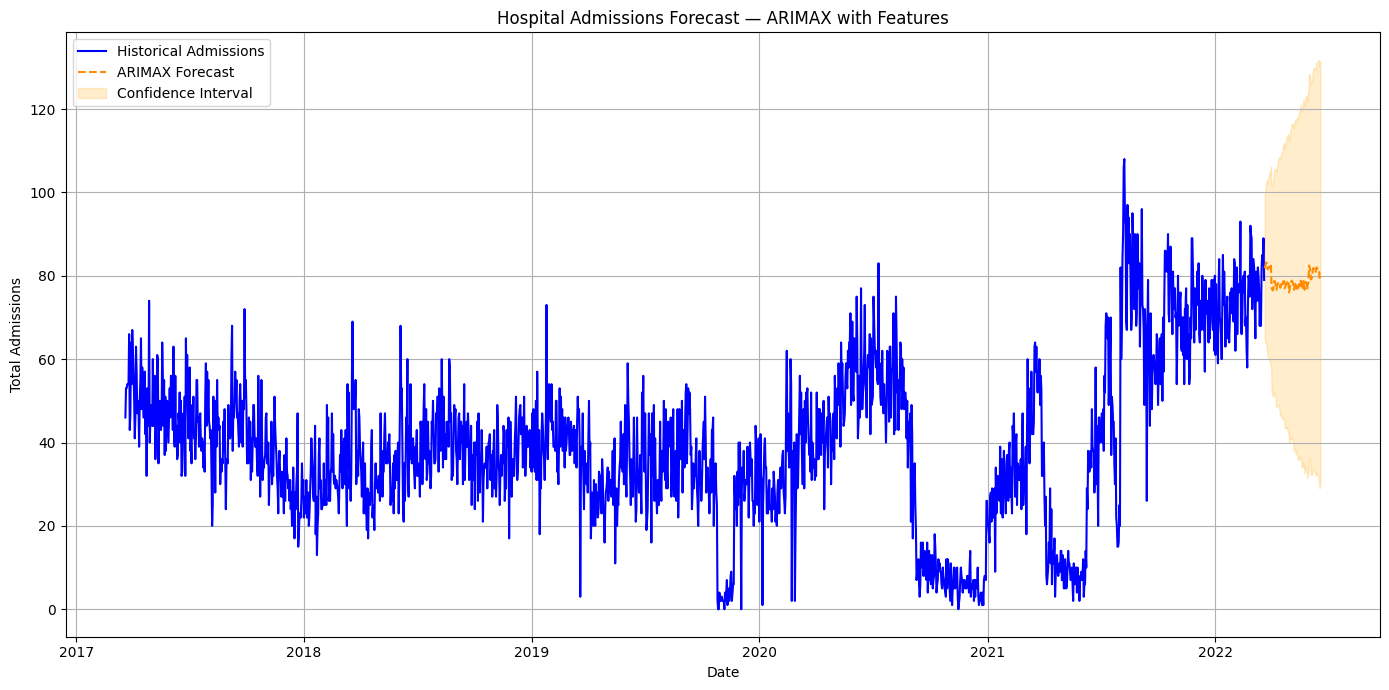


Forecast Preview:
           Date  Forecasted_Admissions  Lower_Bound  Upper_Bound
1819 2022-03-21                  81.80        64.64        98.97
1820 2022-03-22                  82.30        63.91       100.70
1821 2022-03-23                  83.06        63.93       102.19
1822 2022-03-24                  83.19        63.39       102.98
1823 2022-03-25                  81.71        61.28       102.13
1824 2022-03-26                  81.55        60.51       102.58
1825 2022-03-27                  82.16        60.53       103.79
1826 2022-03-28                  81.90        59.69       104.11
1827 2022-03-29                  82.30        59.53       105.08
1828 2022-03-30                  81.97        58.64       105.30
1829 2022-03-31                  82.43        58.57       106.29
1830 2022-04-01                  77.20        52.81       101.59
1831 2022-04-02                  76.67        51.77       101.58
1832 2022-04-03                  76.49        51.08       101.90
1833 2

In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
 
# === Step 1: Load data ===
hospital_data = pd.read_csv('feature_engineering_data.csv')
hospital_data['ResidentDate'] = pd.to_datetime(hospital_data['ResidentDate'])
hospital_data.set_index('ResidentDate', inplace=True)
 
# === Step 2: Define target & exogenous variables ===
y = hospital_data['Total_Admissions']
 
exog_vars = [
    'is_weekend', 'season', 'temperature_max', 'temperature_min',
    'temp_range', 'precipitation', 'is_rain',
    'Festival', 'pandemic_flag', 'disaster_flag'
]
exog = hospital_data[exog_vars]
 
# === Step 3: Stationarity check ===
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("✅ Stationary time series.")
    else:
        print("❌ Not stationary — differencing needed.")
 
print("Original Series:")
test_stationarity(y)
 
# === Step 4: Fit ARIMAX Model ===
# ARIMA(p,d,q) — d=1 if not stationary
p, d, q = 1, 1, 1  # Typical starter values
arimax_model = SARIMAX(y, exog=exog, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
arimax_results = arimax_model.fit(disp=False)
 
# === Step 5: Forecasting ===
forecast_steps = 90
 
# Use the last known 90 exogenous rows for prediction — usually you update this for the real world
future_exog = exog.iloc[-forecast_steps:].copy()
 
forecast = arimax_results.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
 
# === Step 6: Visualization ===
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Historical Admissions', color='blue')
plt.plot(forecast_index, forecast_mean, label='ARIMAX Forecast', color='darkorange', linestyle='--')
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.2, label='Confidence Interval')
plt.title('Hospital Admissions Forecast — ARIMAX with Features')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 
# === Step 7: Print Forecast Table ===
forecast_table = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Admissions': forecast_mean.round(2),
    'Lower_Bound': forecast_ci.iloc[:, 0].round(2),
    'Upper_Bound': forecast_ci.iloc[:, 1].round(2)
})
 
print("\nForecast Preview:")
print(forecast_table.head(15))

21:11:14 - cmdstanpy - INFO - Chain [1] start processing
21:11:15 - cmdstanpy - INFO - Chain [1] done processing


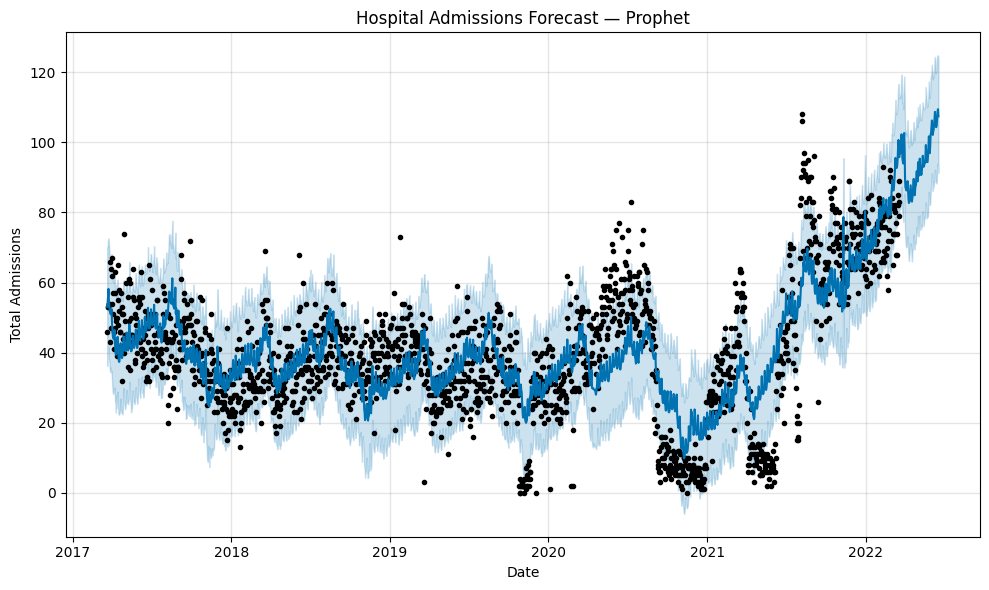

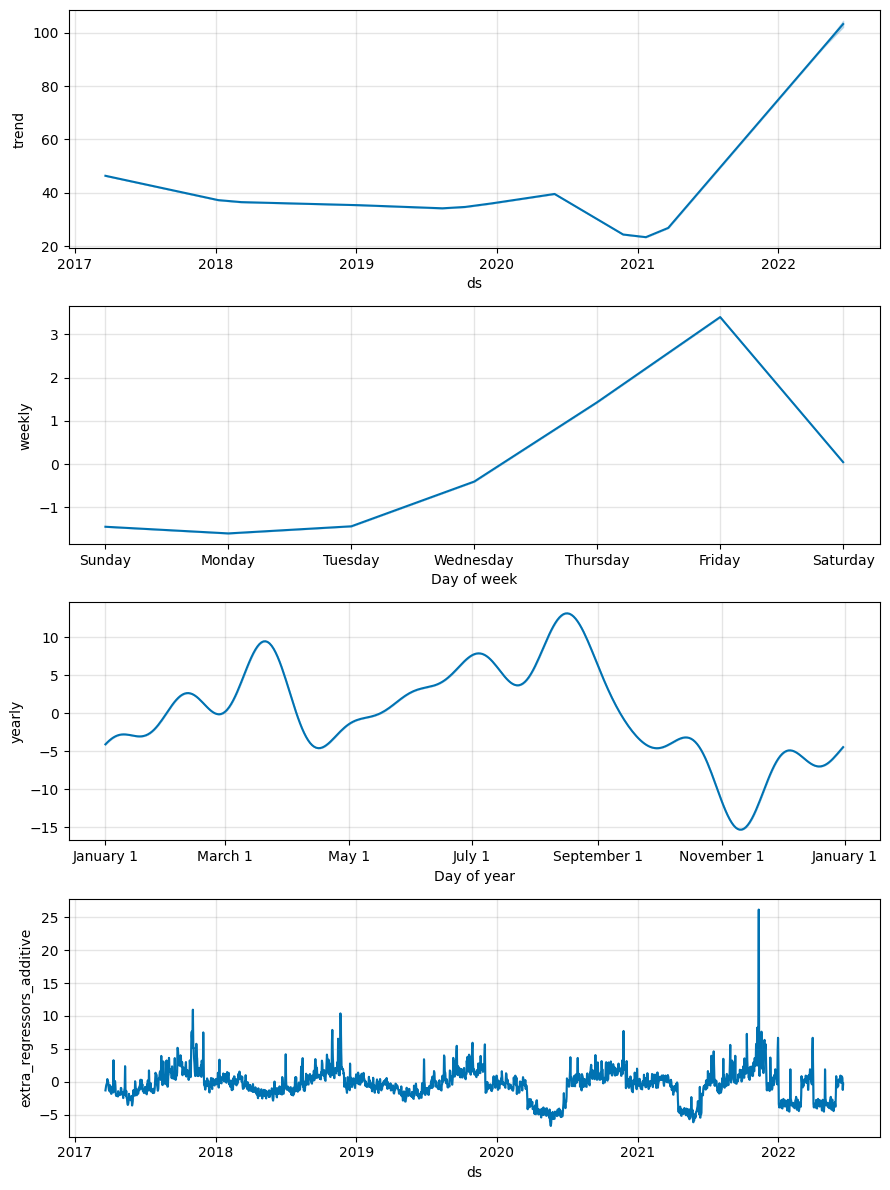


Forecast Preview:
           Date  Forecasted_Admissions  Lower_Bound  Upper_Bound
1819 2022-03-21              97.149010    81.335941   113.662060
1820 2022-03-22              96.882893    80.997927   112.958267
1821 2022-03-23              98.408506    81.880872   112.736432
1822 2022-03-24             101.071881    85.203833   117.692765
1823 2022-03-25             102.324056    87.257481   119.340684
...         ...                    ...          ...          ...
1904 2022-06-14             104.805646    88.265192   122.197890
1905 2022-06-15             107.076123    92.175614   124.441146
1906 2022-06-16             108.938188    93.941627   124.875313
1907 2022-06-17             109.474803    93.361378   124.741354
1908 2022-06-18             107.448767    91.343335   123.117005

[90 rows x 4 columns]


In [12]:
# === Step 1: Install and import Prophet ===
# If not installed, uncomment below:
# !pip install prophet

from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json

# === Step 2: Prepare Data for Prophet ===
# Prophet expects two columns: 'ds' (date) and 'y' (target variable)

prophet_data = hospital_data.reset_index()[['ResidentDate', 'Total_Admissions']].rename(
    columns={'ResidentDate': 'ds', 'Total_Admissions': 'y'}
)

# Optional: Add exogenous features (holidays, etc.) separately if needed

# === Step 3: Add Regressors (optional) ===
# Prophet can take extra regressors — similar to exogenous variables in ARIMAX

m = Prophet()

# Add extra regressors
for col in exog_vars:
    m.add_regressor(col)

# Combine exog variables with target for training
prophet_full = pd.concat([prophet_data, hospital_data[exog_vars].reset_index(drop=True)], axis=1)

# === Step 4: Fit the Prophet Model ===
m.fit(prophet_full)

# === Step 5: Create Future DataFrame ===
future = m.make_future_dataframe(periods=90, freq='D')

# Add exogenous features to future dataframe
future_exog = hospital_data[exog_vars].iloc[-90:].reset_index(drop=True)
future = pd.concat([future.iloc[-90:].reset_index(drop=True), future_exog], axis=1)
future_full = pd.concat([prophet_full[['ds'] + exog_vars], future], axis=0)

# === Step 6: Forecast ===
forecast = m.predict(future_full)

# === Step 7: Visualization ===
m.plot(forecast)
plt.title("Hospital Admissions Forecast — Prophet")
plt.xlabel("Date")
plt.ylabel("Total Admissions")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot components
m.plot_components(forecast)
plt.tight_layout()
plt.show()

# === Step 8: Forecast Table ===
forecast_table = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90)
forecast_table = forecast_table.rename(columns={
    'ds': 'Date',
    'yhat': 'Forecasted_Admissions',
    'yhat_lower': 'Lower_Bound',
    'yhat_upper': 'Upper_Bound'
})

print("\nForecast Preview:")
print(forecast_table.head(90))
